In [2]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEstV2,max_norm,ApproxDAP,find_stable_radius
from time import time
from controllers import SafeDAP
from scipy.linalg import sqrtm
%load_ext autoreload
%autoreload 2

# Find a highly stable spring-mass system

Spectral radius of A: 0.9508241019243413 0.27710574943567934 0.9870458469412658
Step 0
Step 100
Step 0
Step 100


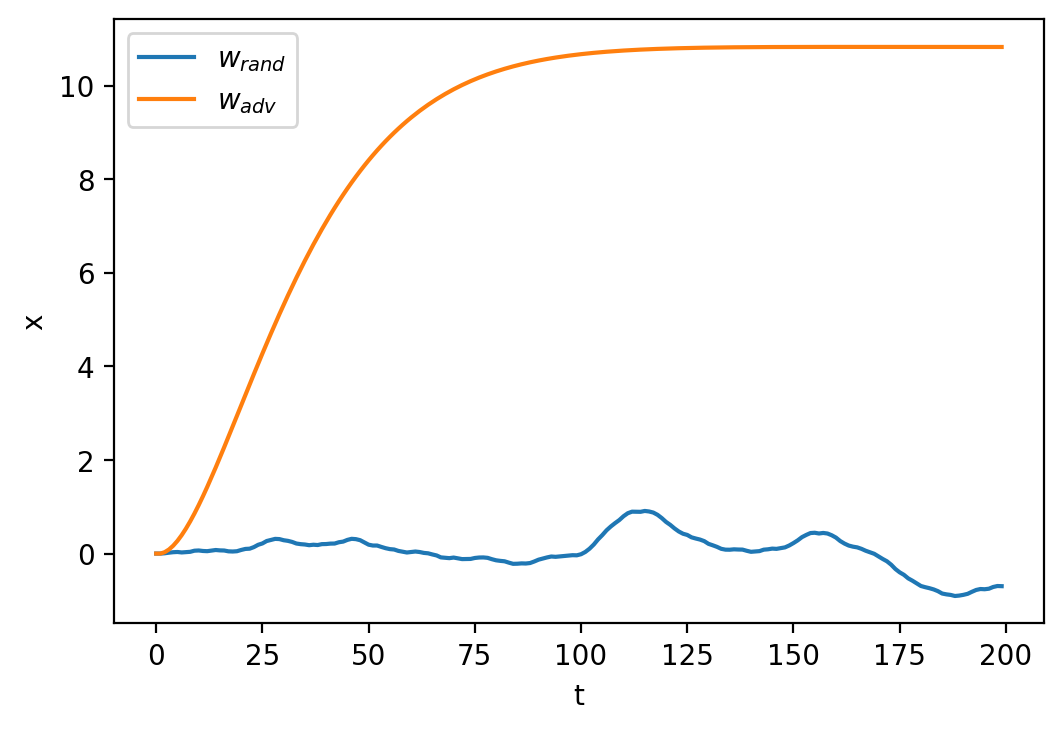

In [3]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.1
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [5]:
find_stable_radius(env.A)

0.019090909090909092

In [29]:
est = ModelEstV2(A,B,eps_init)

[autoreload of Subroutines failed: Traceback (most recent call last):
  File "/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 851, in exec_module
  File "<frozen importlib._bootstrap_external>", line 988, in get_code
  File "<frozen importlib._bootstrap_external>", line 918, in source_to_code
  File "<frozen importlib._bootstr

In [7]:
est.est(x_hist,u_hist)

(array([[ 1.        ,  0.1       ],
        [-0.02407397,  0.91139247]]),
 array([[-1.94456637e-16],
        [ 1.01548643e-01]]),
 0.12262786789699316)

In [4]:
H = 20 # Look back length

eta_bar = 0.4 # The magnitude of exploration noise.


# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.



# Inputs to SafeDAP


Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([4,6.0,4,6.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([6,6])

w_max = env.w_max# w_max should be less than env.w_max for the problem to stay feasible.


env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0



# # Pre-run steps 

x_hist = []
u_hist = []
w_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 400
resolve_per_steps = 20
pre_run_steps = 20
theta_hist = []

# main loop
for _ in range(time_steps):
    x = env.state()
    x_hist.append(x)
    u = (np.random.rand()-0.5)*2*eta_bar

    env.step(u)
    u_hist.append(u)

In [5]:
A_hat,B_hat,r = ModelEst(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim),stability_gap=0.04)